## Broomstick Problem - Angular distribution

A "broomstick" problem is a long narrow cylinder with a pencil beam along its axis. After one collission, neutrons exit the cylinder and we can tally the outgoing energy or angle distribution.

In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
openmc.config['cross_sections'] = '/home/student/openmc_ncrystal_vm/endfb-viii.0-hdf5/cross_sections.xml'

We start defining a function that returns an OpenMC model for a the broomstick, with a monoenergetic pencil beam and an angular segmented current tally on its surface.

In [2]:
def create_model(broomstick_mat, E0=0.95, Emin=0, Emax=20e6, NParticles=1000000, broomstick_diameter=0.001, broomstick_length=10000):
    p1 = openmc.ZPlane(z0=-broomstick_length/2)
    p2 = openmc.ZPlane(z0=+broomstick_length/2)
    c1 = openmc.ZCylinder(r=broomstick_diameter)
    s1 = openmc.Sphere(r=broomstick_length*1.5, boundary_type='vacuum')
    cell1 = openmc.Cell(region=+p1&-p2&-c1, fill=broomstick_mat)
    cell2 = openmc.Cell(region=~(+p1&-p2&-c1)&-s1, fill=None)
    u1 = openmc.Universe(cells=[cell1, cell2])
    geometry = openmc.Geometry(root=u1)
    
    source = openmc.Source()
    source.space  = openmc.stats.Point(xyz=[0,0,0])
    source.angle  = openmc.stats.Monodirectional(reference_uvw=[0,0,1])
    source.energy = openmc.stats.Discrete([E0], [1.0])
    
    settings = openmc.Settings()
    settings.source = source
    settings.run_mode = 'fixed source'
    settings.batches = 10
    settings.particles = NParticles
    settings.temperature = {'method':'nearest', 'tolerance':1000}

    tally1 = openmc.Tally()
    filter1 = openmc.SurfaceFilter([c1])
    filter2 = openmc.EnergyFilter([Emin, Emax])
    filter3 = openmc.PolarFilter(np.arccos(np.linspace(1,-1,101)))
    tally1.scores = ['current']
    tally1.name = 'angdist'
    tally1.filters = [filter1, filter2, filter3]
    tallies = openmc.Tallies([tally1])
    
    return openmc.model.Model(geometry=geometry, settings=settings, tallies=tallies)

We will define a pair of functions to extract the spectra from the statepoint file:

In [3]:
def get_angular_tally(spfile='statepoint.10.h5'):
    with openmc.StatePoint(spfile) as sp:
        tally = sp.get_tally(name='angdist')
        df = tally.get_pandas_dataframe()
        phi = df['mean'].values
        mu = np.cos(df['polar high [rad]'].values)
        return mu, phi

We can now apply this to the calculation of the angular distribution in different materials:

In [4]:
m1 = openmc.Material()
m1.add_elements_from_formula('CH2')
m1.set_density('g/cm3', 0.92)
m1.add_s_alpha_beta('c_H_in_CH2')

model = create_model(m1, E0=0.95, Emin=2.73e-1, Emax=3.01e-1)
model.export_to_xml()

In [5]:
!rm summary.h5 statepoint.10.h5
openmc.run(output=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

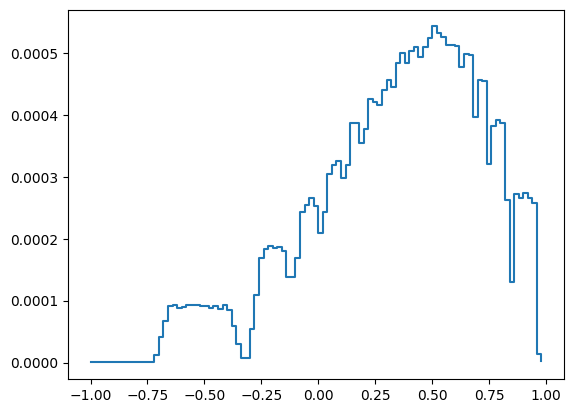

In [6]:
mu1, phi1 = get_angular_tally('statepoint.10.h5')
plt.step(mu1,phi1)

We can compare the results of the transmission simulation with the macroscopic total cross section for the material:

In [7]:
m1 = openmc.Material.from_ncrystal('Polyethylene_CH2.ncmat')
model = create_model(m1, E0=0.95, Emin=2.73e-1, Emax=3.01e-1)
model.export_to_xml()

!rm summary.h5 statepoint.10.h5
openmc.run(output=True)

mu2, phi2 = get_angular_tally('statepoint.10.h5')

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

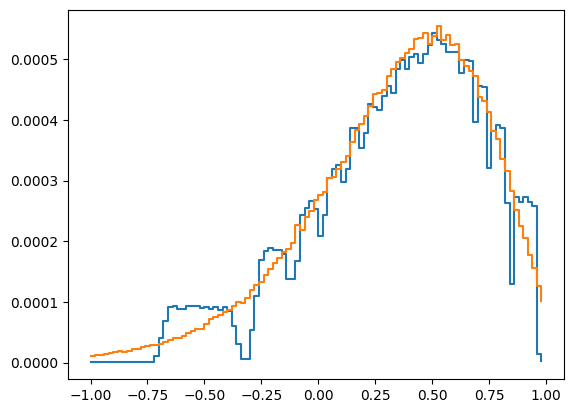

In [8]:
plt.step(mu1,phi1)
plt.step(mu2,phi2)